# Econometric Analysis of Games Assignment 1
**Zhu Dai 2021200179**

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy import integrate
from scipy.optimize import minimize
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

## Exercise 1
Auction based private placement in China's A-share market. \
**Auctioned object**: new shares of the company \
**Rule of auction**: \
(1) Only institutional investors and high-net-worth individuals could participate, typically no more than 35 qualified investors per auction. \
(2) There is a reserved price, bids must exceed the reserved price. \
(3) Investors submit their bids including the number of shares and the price they're willing to offer, investors are allowed to place multiple bids at different price levels. \
(4) Bids would be ranked from highest price to lowest price, then shares would be allocated from the highest price bids. The lowest price where all shares are sold is called cut-off price. \
(5) Those allocated shares are sold at the cut-off price. \
(6) Investors who get the shares are subject to a lock-up period that they can't sell those shares. \
**Type**: a uniformed-price auction, every participant would get the goods with the same price. \

## Exercise 2
Let $F(b)$ represents the value distribution, $r$ represents the reserve price. \

#### Question 2.1
Since it's second price auction, the optimal strategy is $b=v$. \
(1) If $v_1,v_2<r$, expected payment: $$0×F(r)^2=0$$ \
(2) If $v_1<r<v_2$ or $v_2<r<v_1$, expected return: $$r×F(r)×(1-F(r))×2=2rF(r)(1-F(r))$$ \
(3) If $v_1,v_2>r$, expected return: $$2\int_r^\infty b(1-F(b))f(b)db$$ \
As a result, the expected payoff \

$$
\begin{aligned}
& 0 + 2rF(r)(1 - F(r)) + 2\int_r^\infty b(1 - F(b))f(b)db - 0 \\
= & 2rF(r)(1 - F(r)) + 2\int_r^\infty b(1 - F(b))f(b)db
\end{aligned}
$$


####  Question 2.2
(1) If $v_i<r$, expected payment: $$0×F(r)^4=0$$ \
(2) If $v_{(1)}>r,v_i<r,v_{(1)}\neq v_i$, expected payment: $$ r×F(r)^3×(1-F(r))×4=4rF(r)^3(1-F(r))$$ \
(3) Other circumstance, expected payment: 
$$
\begin{aligned}
& \int_r^\infty b dP(v_{2:n}\leq b) \\
= & \int_r^\infty bd(P(v_{1:n} \leq b)+ P(v_{1:n}>b,v_{2:n} \leq b)) \\
= & \int_r^\infty bd(F(b)^4+4(1-F(b))F(b)^3) \\ 
= & 12\int_r^\infty b(1-F(b))F(b)^2f(b)db
\end{aligned}
$$ \
As a result, the expected payoff \
$$
\begin{aligned}
& 0+4rF(r)^3(1-F(r))+12\int_r^\infty b(1-F(b))F(b)^2f(b)db-0 \\
= & 4rF(r)^3(1-F(r))+12\int_r^\infty b(1-F(b))F(b)^2f(b)db
\end{aligned}
$$ \



#### Question 2.3
First we define function to calculate the payoff using the general formula of n bidders. \
We could summary a general form of the profit function from the questions above. \
$$
v_sF(r)^n+nrF(r)^{n-1}(1-F(r))+n(n-1)\int_r^\infty b(1-F(b))F(b)^{n-2}f(b)db-v_s
$$

In [122]:
def spa_payoff(r,n,vs,F,f):
    '''
    This function describe a general form of the payoff in second price auction.
    input:
        n: number of bidder
        r: list, reserve price
        vs: auctioneer's value
        F: value distribution of bidders
        f: value density of bidders
    output:
        payoff of auctioneer
    '''
    payment1 = vs*np.power(F(r),n) # if bids are all below reserve price
    payment2 = n*r*np.power(F(r),n-1)*(1-F(r)) # if only one bid is above reserve price
    intg_func3 = lambda x:x*(1-F(x))*np.power(F(x),n-2)*f(x)
    payment3 = []
    for i in range(len(r)):
        payment3.append(n*(n-1)*integrate.quad(intg_func3,r[i],np.inf)[0]) # if more than two bids are above reserve price
    return payment1+payment2+np.array(payment3)-vs

Then we calculate the function value with different x.

In [123]:
%%time
# calculate
r = np.linspace(0,1,100) # reserve price
vs = 0 # auctioneer's value
F = lambda x:stats.uniform.cdf(x,0,1) # uniform value distribution
f = lambda x:stats.uniform.pdf(x,0,1)

n1 = 2 # number of bidder
payoff1 = spa_payoff(r,n1,vs,F,f) # payoff

n2 = 4
payoff2 = spa_payoff(r,n2,vs,F,f)

CPU times: total: 11 s
Wall time: 23.7 s


Finally we use matplotlib to plot the profit function.

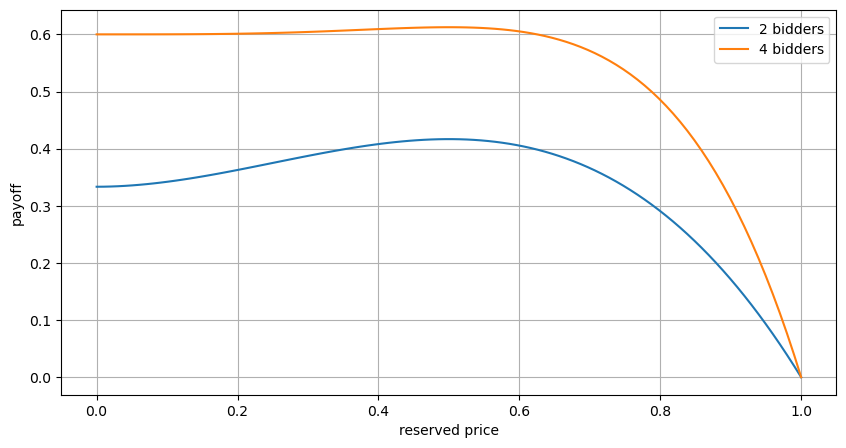

In [154]:
# plot
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(r,payoff1,label=str(n1)+' bidders')
ax.plot(r,payoff2,label=str(n2)+' bidders')
ax.set_xlabel('reserved price')
ax.set_ylabel('payoff')
ax.grid()
ax.legend()
plt.show()

From the image, we know that \
(1) Regardless of the reserve price, the profit increases when the number of bidders increases from 2 to 4. \
(2) With 4 bidders, the profit function's first derivative appears to be smaller at lower reserve prices and larger at higher reserve prices, as indicated by the flatness and steepness of the plot.

#### Question 2.4
Here we use optimize algorithm in Scipy to calculate the optimal reserve price.

In [138]:
%%time
# exchange into an minimize question
def neg_spa_payoff(r, n, vs, F, f):
    return -spa_payoff(r, n, vs, F, f)

# calculate
vs = 0 # auctioneer's value
F = lambda x:stats.uniform.cdf(x,0,1) # uniform value distribution
f = lambda x:stats.uniform.pdf(x,0,1)

n1 = 2 # 2 bidders
opt1 = minimize(neg_spa_payoff,[1], args=(n1, vs, F, f), method='Nelder-Mead')
r_opt1 = opt1.x[0]

n2 = 4 # 2 bidders
opt2 = minimize(neg_spa_payoff,[1], args=(n2, vs, F, f), method='Nelder-Mead')
r_opt2 = opt2.x[0]

print('Reserve price for '+str(n1)+' bidders is '+str(round(r_opt1,1))+' while reserve price for '+str(n2)+' bidders is '+str(round(r_opt2,1)))

Reserve price for 2 bidders is 0.5 while reserve price for 4 bidders is 0.5
CPU times: total: 2.84 s
Wall time: 9.95 s


We find the reserve price is totally the same regardless of the number of bidders, then we plot it in the image of profit functions.

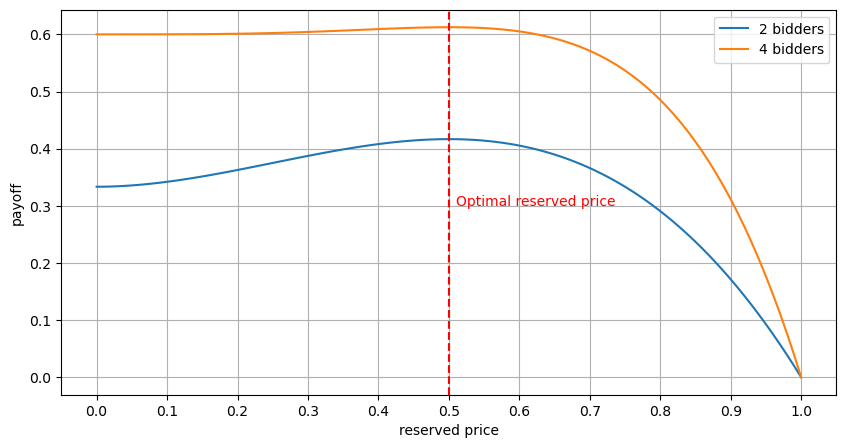

In [155]:
# plot
# plot
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(r,payoff1,label=str(n1)+' bidders')
ax.plot(r,payoff2,label=str(n2)+' bidders')
ax.axvline(x=r_opt1, ymin=0, ymax=1, color='r', linestyle='--') # reserved price
ax.text(r_opt1+0.01,0.3, 'Optimal reserved price',color='r')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_xlabel('reserved price')
ax.set_ylabel('payoff')
ax.grid()
ax.legend()
plt.show()

#### Question 2.5
The formula of optimal reserve price given in class is $r=v_s+\frac{(1-F(r))}{f(r)}$ \
Since we know the value distribution is a uniform distribution, we have $$F(r)=r,r\in [0,1]$$ \
$$f(r)=1,r \in [0,1]$$ \
Then $$r=\frac{1-r}{1}$$ \
$$r=\frac{1}{2}$$ \
The result is same as the one under the numerical solution. \